## REVIEWS

In [1]:
import pandas as pd
import spacy
import re
import nltk
import numpy as np

nlp = spacy.load("it_core_news_sm")

### Jolie vs Inissia

In [108]:
jolie = pd.read_csv('Lavazza_Jolie_reviews.csv', encoding='utf8')
inissia = pd.read_csv('Nespresso_Inissia_reviews.csv', encoding='utf8')

print("INITIAL STATISTICS")
print("Entries jolie: ", len(jolie))
print("Entries jolie: ", len(inissia), "\n\n")
print('Inissia\n',inissia.head(5),'\n')
print('Jolie\n',jolie.head(5),'\n')

INITIAL STATISTICS
Entries jolie:  1882
Entries jolie:  3663 


Inissia
              stars                                            comment
0  4,6 su 5 stelle  Ho avuto per anni la Bialetti: sempre problemi...
1  5,0 su 5 stelle  La Nespresso Inissia di Krups è un prodotto sp...
2  1,0 su 5 stelle                                      +++++PRO+++++
3  5,0 su 5 stelle  - Occupa pochissimo spazio: come è possibile v...
4  5,0 su 5 stelle  - È possibile utilizzarla con qualsiasi capsul... 

Jolie
              stars                                            comment
0  5,0 su 5 stelle  Comprata per un regalo (la vecchia macchinetta...
1  4,0 su 5 stelle  Appena ricevuta l'ho provata con le capsule la...
2  5,0 su 5 stelle  Il prodotto si presenta come da descrizione, p...
3  5,0 su 5 stelle  ~~~~~~~~ Motivo dell'acquisto ~~~~~~~~Volevamo...
4  2,0 su 5 stelle  Insomma... Avevo una minu che si è fulminata c... 



In [109]:
jolie['brand'] = 'Lavazza'
inissia['brand'] = 'Nespresso'

df = pd.concat([jolie,inissia], ignore_index=True)
df

,stars,comment,brand
0,"5,0 su 5 stelle",Comprata per un regalo (la vecchia macchinetta...,Lavazza
1,"4,0 su 5 stelle",Appena ricevuta l'ho provata con le capsule la...,Lavazza
2,"5,0 su 5 stelle","Il prodotto si presenta come da descrizione, p...",Lavazza
3,"5,0 su 5 stelle",~~~~~~~~ Motivo dell'acquisto ~~~~~~~~Volevamo...,Lavazza
4,"2,0 su 5 stelle",Insomma... Avevo una minu che si è fulminata c...,Lavazza
...,...,...,...
5540,"5,0 su 5 stelle",mi e piaciuto tutto,Nespresso
5541,"5,0 su 5 stelle",Ottima macchina del caffè con le cialde Nespre...,Nespresso
5542,"5,0 su 5 stelle","Facile da usare, occupa poco spazio e di buon ...",Nespresso
5543,"5,0 su 5 stelle",Buona,Nespresso


In [110]:
df['rate'] =  df['stars'].str[:1]

# seems that there is a string value in the rate column
print(pd.unique(df['rate']))
print(df['rate'].value_counts())
df = df[df.rate != 's']

# now we can proceed
df['rate'] = df['rate'].astype(int)
df = df.replace('\n',' ', regex=True)
df = df.replace('~','', regex=True)
df = df.replace('-','', regex=True)
df = df.replace('Ottimo','', regex=True)
df = df.replace('ottimo','', regex=True)
df = df.replace('Ottima','', regex=True)
df = df.replace('ottima','', regex=True)
df = df[df.comment.isna()==False]
df = df[df.rate.isna()==False]
df

['5' '4' '2' '3' '1']
5    3682
4    1094
1     452
3     216
2     101
Name: rate, dtype: int64


,stars,comment,brand,rate
0,"5,0 su 5 stelle",Comprata per un regalo (la vecchia macchinetta...,Lavazza,5
1,"4,0 su 5 stelle",Appena ricevuta l'ho provata con le capsule la...,Lavazza,4
2,"5,0 su 5 stelle","Il prodotto si presenta come da descrizione, p...",Lavazza,5
3,"5,0 su 5 stelle",Motivo dell'acquisto Volevamo da tempo una ma...,Lavazza,5
4,"2,0 su 5 stelle",Insomma... Avevo una minu che si è fulminata c...,Lavazza,2
...,...,...,...,...
5540,"5,0 su 5 stelle",mi e piaciuto tutto,Nespresso,5
5541,"5,0 su 5 stelle",macchina del caffè con le cialde Nespresso il...,Nespresso,5
5542,"5,0 su 5 stelle","Facile da usare, occupa poco spazio e di buon ...",Nespresso,5
5543,"5,0 su 5 stelle",Buona,Nespresso,5


In [111]:
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}
            and token.text])

df['comment_cleaned'] = df.apply(lambda x: clean(x.comment), axis=1)
print("database cleaned:")
print("Entries: ", len(df), "\n\n")

database cleaned:
Entries:  5545 




In [112]:
df = df.drop(['stars','comment'], axis = 1)
df = df.replace('macchinare','macchinetta', regex=True)
df.head(5)

,brand,rate,comment_cleaned
0,Lavazza,5,Comprata regalare vecchio macchinetta rotto di...
1,Lavazza,4,Appena ricevere provato capsula lavazza dotazi...
2,Lavazza,5,produrre presentire come descrizione praticare...
3,Lavazza,5,Motivo della acquistare Volevamo tempo macchin...
4,Lavazza,2,Insomma Avevo minu fulminato temporale fretta ...


### NMF

In [116]:
documents = df.comment_cleaned.apply(str).tolist()

In [117]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(0,1), 
                                   stop_words=None, 
                                   analyzer='word', 
                                   min_df=0.01, 
                                   max_df=0.8, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(5545, 229)


In [118]:
from sklearn.decomposition import NMF

k = 8

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

print(W.shape, H.shape)

CPU times: user 387 ms, sys: 30.7 ms, total: 418 ms
Wall time: 181 ms
(5545, 8) (8, 229)


In [119]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

terms = tfidf_vectorizer.get_feature_names()

print("\nNMF:")
print(*show_topics(H, terms),sep = "\n")

NMF_descriptors = show_topics(H, terms)


NMF:
essere, non, capsula, anche, compatibile
produrre, buon, spedizione, già, consegnare
usare, facile, pulire, semplice, utilizzare
prezzo, qualità, rapportare, buon, buono
caffè, macchinetta, fare, buono, bar
acquistare, consigliare, regalare, soddisfatto, secondo
molto, bene, buono, bello, macchina
perfetto, tempo, spedizione, arrivato, consegnare


In [120]:
sb.set_context('notebook')

def plot_vectors(vectors, title='VIZ', labels=None, dimensions=3):
    """
    plot the vectors in 2 or 3 dimensions. 
    If labels are supplied, use them to color the data accordingly
    """
    # set up graph
    fig = plt.figure(figsize=(8,8))

    # create data frame
    df = pd.DataFrame(data={'x':vectors[:,0], 'y': vectors[:,1]})
    # add labels, if supplied
    if labels is not None:
        df['label'] = labels
    else:
        df['label'] = [''] * len(df)

    # assign colors to labels
    cm = plt.get_cmap('afmhot') # choose the color palette
    n_labels = len(df.label.unique())
    label_colors = [cm(1. * i/n_labels) for i in range(n_labels)]
    cMap = colors.ListedColormap(label_colors)
        
    # plot in 3 dimensions
    if dimensions == 3:
        # add z-axis information
        df['z'] = vectors[:,2]
        # define plot
        ax = fig.add_subplot(111, projection='3d')
        frame1 = plt.gca() 
        # remove axis ticks
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])
        frame1.axes.zaxis.set_ticklabels([])

        # plot each label as scatter plot in its own color
        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], df2['z'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)
      
    # plot in 2 dimensions
    elif dimensions == 2:
        ax = fig.add_subplot(111)
        frame1 = plt.gca() 
        frame1.axes.xaxis.set_ticklabels([])
        frame1.axes.yaxis.set_ticklabels([])

        for l, label in enumerate(df.label.unique()):
            df2 = df[df.label == label]
            color_values = [label_colors[l]] * len(df2)
            ax.scatter(df2['x'], df2['y'], 
                       c=color_values, 
                       cmap=cMap, 
                       edgecolor=None, 
                       label=label, 
                       alpha=0.4, 
                       s=100)

    else:
        raise NotImplementedError()

    plt.title(title)
#     plt.legend()
    plt.show()

In [121]:
dfs = df.sample(frac=1).reset_index(drop=True)   
low_dim_nmf = NMF(n_components=3, init='nndsvd')

Z = X[:200]
categories = dfs.brand[:200]
low_dim_W = low_dim_nmf.fit_transform(Z)

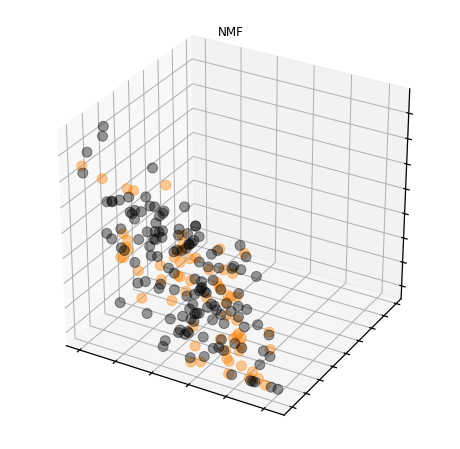

In [122]:
plot_vectors(low_dim_W, title='NMF', labels=categories, dimensions=3)

In [123]:
target_category = 'brand'
scores = W
NMF_topic_distros = pd.DataFrame(data=scores, columns=NMF_descriptors)
NMF_topic_distros['category'] = df[target_category]
NMF_topic_distros.head(4)

,"essere, non, capsula, anche, compatibile","produrre, buon, spedizione, già, consegnare","usare, facile, pulire, semplice, utilizzare","prezzo, qualità, rapportare, buon, buono","caffè, macchinetta, fare, buono, bar","acquistare, consigliare, regalare, soddisfatto, secondo","molto, bene, buono, bello, macchina","perfetto, tempo, spedizione, arrivato, consegnare",category
0,0.092187,0.000370,0.000000,0.001714,0.051938,0.005516,0.046428,0.001559,Lavazza
1,0.072664,0.000000,0.000000,0.001800,0.059656,0.003118,0.047660,0.000000,Lavazza
2,0.072681,0.069575,0.001604,0.017124,0.026442,0.035649,0.000000,0.006752,Lavazza
3,0.090384,0.000000,0.000000,0.038555,0.063018,0.032429,0.063819,0.000000,Lavazza



NMF:
essere, non, capsula, anche, compatibile
produrre, buon, spedizione, già, consegnare
usare, facile, pulire, semplice, utilizzare
prezzo, qualità, rapportare, buon, buono
caffè, macchinetta, fare, buono, bar
acquistare, consigliare, regalare, soddisfatto, secondo
molto, bene, buono, bello, macchina
perfetto, tempo, spedizione, arrivato, consegnare




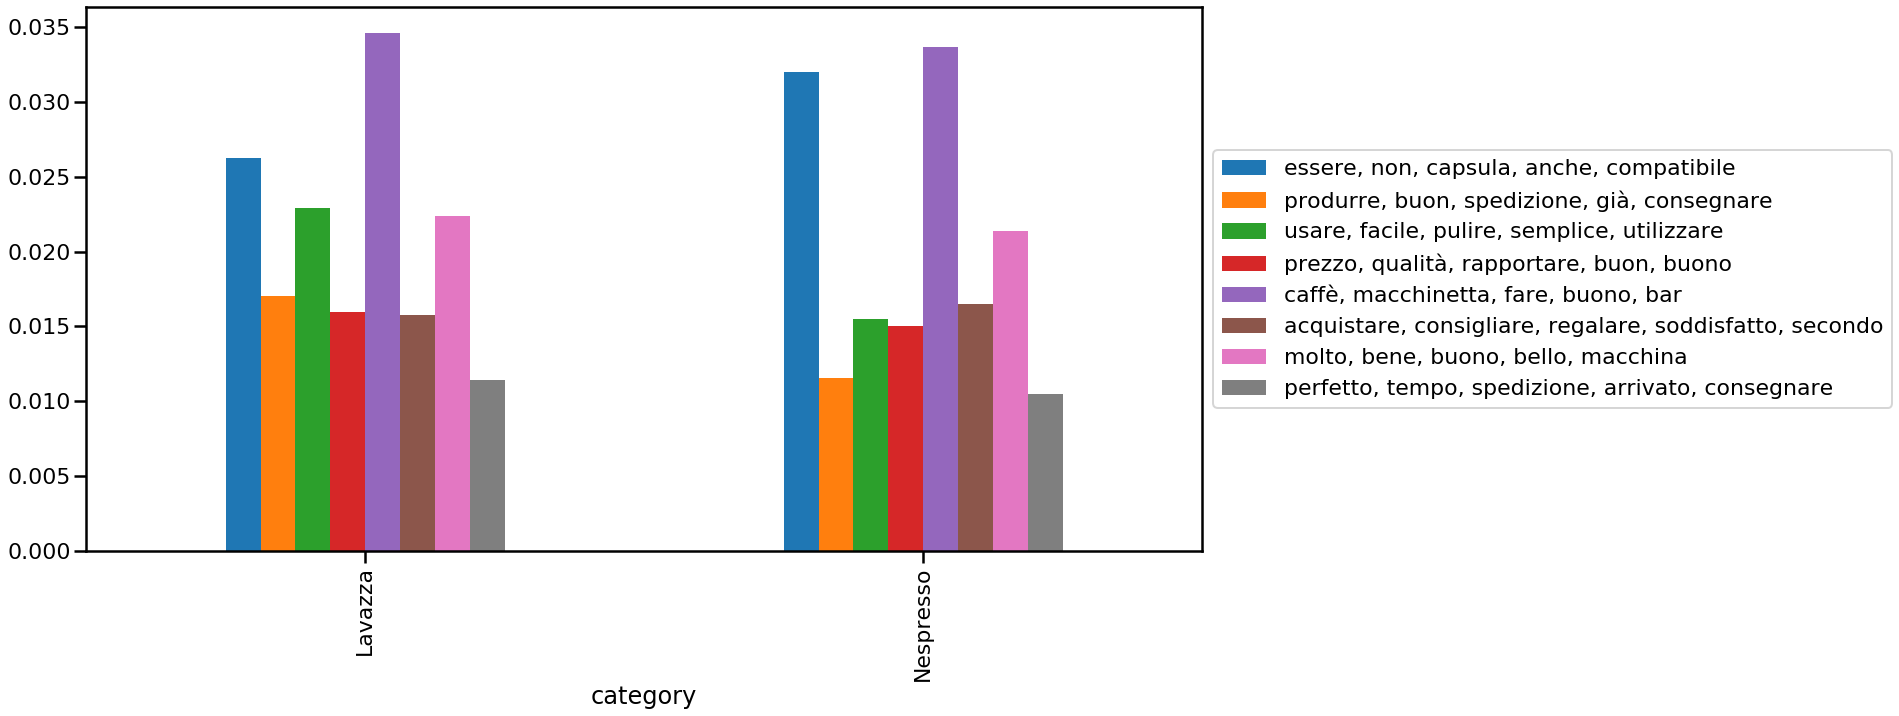

In [124]:
print("\nNMF:")
print(*show_topics(H, terms),sep = "\n")
print('\n')
import matplotlib.pyplot as plt
import seaborn 
seaborn.set_context('poster')
fig, ax = plt.subplots(figsize=(20, 10))

# aggregate topics by categories
NMF_aggregate_by_category = NMF_topic_distros[NMF_topic_distros.category.isin('Nespresso Lavazza'.split())]
NMF_aggregate_by_category = NMF_aggregate_by_category.groupby(NMF_aggregate_by_category.category).mean()

# plot the graph
NMF_aggregate_by_category[NMF_descriptors].plot.bar(ax=ax)

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [127]:
NMF_aggregate_by_category

,"essere, non, capsula, anche, compatibile","produrre, buon, spedizione, già, consegnare","usare, facile, pulire, semplice, utilizzare","prezzo, qualità, rapportare, buon, buono","caffè, macchinetta, fare, buono, bar","acquistare, consigliare, regalare, soddisfatto, secondo","molto, bene, buono, bello, macchina","perfetto, tempo, spedizione, arrivato, consegnare"
category,,,,,,,,
Lavazza,0.026251,0.017024,0.022917,0.015984,0.034607,0.015763,0.022349,0.011406
Nespresso,0.032013,0.011568,0.015502,0.015057,0.033653,0.016514,0.021374,0.010470


### LDA

In [45]:
from gensim.models import LdaMulticore, TfidfModel, CoherenceModel
from gensim.corpora import Dictionary
import time 
import multiprocessing

In [46]:
instances = df.comment_cleaned.apply(str.split)
dictionary = Dictionary(instances)

In [47]:
dictionary.filter_extremes(no_below=50, no_above=0.40)
print("Dict created.", dictionary, flush=True)

Dict created. Dictionary(254 unique tokens: ['acqua', 'alla', 'anche', 'andare', 'avere']...)


In [48]:
print("translating corpus to IDs", flush=True)
ldacorpus = [dictionary.doc2bow(text) for text in instances]

print("tf-idf transformation", flush=True)
tfidfmodel = TfidfModel(ldacorpus)

model_corpus = tfidfmodel[ldacorpus]

translating corpus to IDs
tf-idf transformation


In [49]:
num_topics = 6

# find chunksize to make about 200 updates
num_passes = 10
chunk_size = len(model_corpus) * num_passes/200
print(chunk_size)


start = time.time()
print("fitting model", flush=True)
model = LdaMulticore(num_topics=num_topics, # number of topics
                     corpus=model_corpus, # what to train on 
                     id2word=dictionary, # mapping from IDs to words
                     workers=min(10, multiprocessing.cpu_count()-1), # choose 10 cores, or whatever computer has
                     passes=num_passes, # make this many passes over data
                     chunksize=chunk_size, # update after this many instances
                     alpha=0.5
                    )
    
print("done in {}".format(time.time()-start), flush=True)


277.25
fitting model
done in 20.732622861862183


In [50]:
topic_corpus = model[model_corpus]
topic_sep = re.compile(r"0\.[0-9]{3}\*")
model_topics = [(topic_no, re.sub(topic_sep, '', model_topic).split(' + ')) for topic_no, model_topic in
                model.print_topics(num_topics=num_topics, num_words=5)]

descriptors = []
for i, m in model_topics:
    print(i+1, ", ".join(m[:5]).replace('"', ''))
    descriptors.append(", ".join(m[:2]).replace('"', ''))

1 produrre, prezzo, qualità, acquistare, rapportare
2 facile, usare, semplice, bello, pulire
3 fare, non, compatibile, anche, capsula
4 bene, caffo, veloce, della, sempre
5 poco, rumoroso, essere, acqua, Facile
6 perfetto, consigliare, buon, capsula, buono


### Visualization

In [86]:
target_category = 'brand'

scores = [[t[1] for t in topic_corpus[entry]] for entry in range(len(df))]
topic_distros = pd.DataFrame(data=scores, columns=descriptors)
topic_distros['category'] = df[target_category]

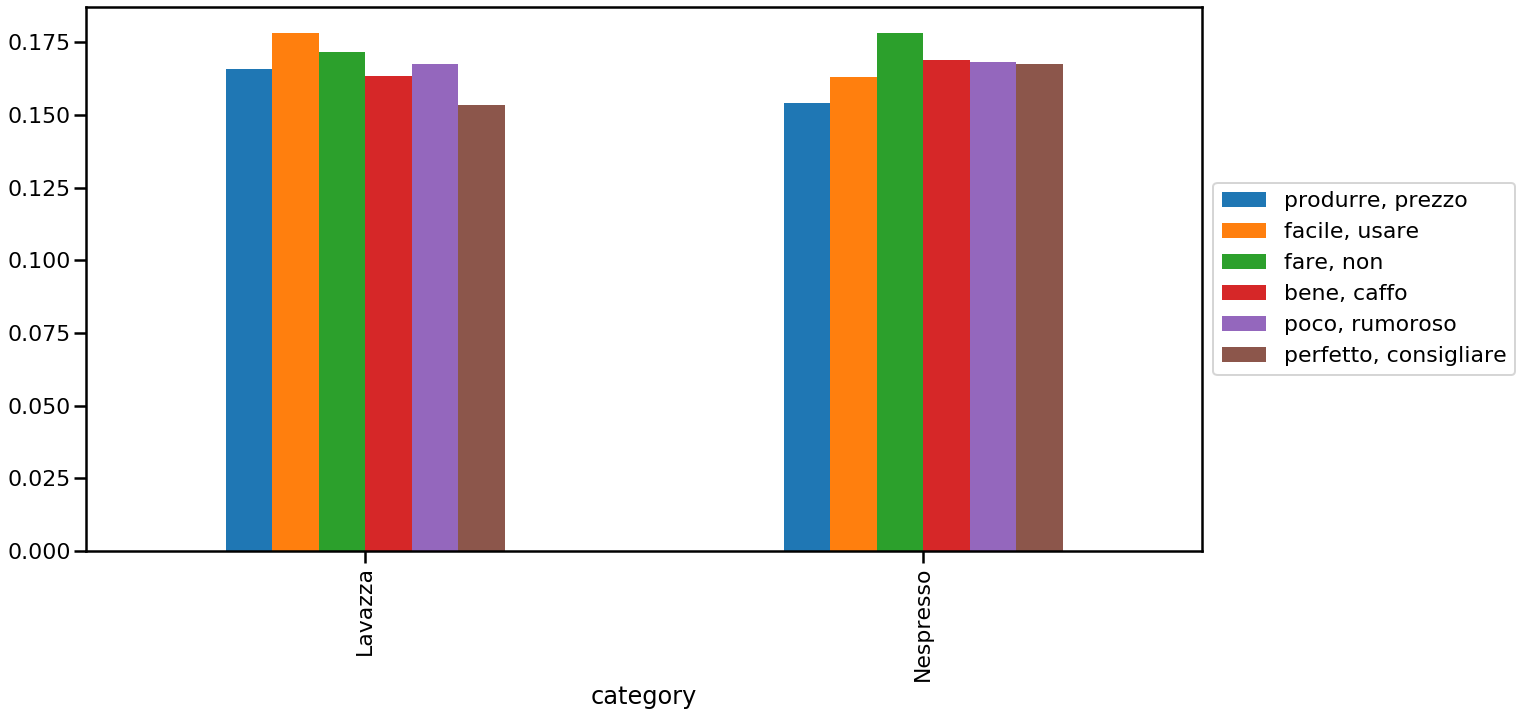

In [54]:
import matplotlib.pyplot as plt
import seaborn 
seaborn.set_context('poster')
fig, ax = plt.subplots(figsize=(20, 10))

# aggregate topics by categories
aggregate_by_category = topic_distros[topic_distros.category.isin('Nespresso Lavazza'.split())]
aggregate_by_category = aggregate_by_category.groupby(aggregate_by_category.category).mean()

# plot the graph
aggregate_by_category[descriptors].plot.bar(ax=ax)

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

### Illy vs Lavazza

In [91]:
illy = pd.read_csv('Illy_Capsule_reviews.csv', encoding='utf8')
lavazza = pd.read_csv('Lavazza_Capsule_reviews.csv', encoding='utf8')

print("INITIAL STATISTICS")
print("Entries Illy: ", len(illy))
print("Entries Lavazza: ", len(lavazza), "\n\n")
print('Illy\n',illy.head(5),'\n')
print('Lavazza\n',lavazza.head(5),'\n')

INITIAL STATISTICS
Entries Illy:  599
Entries Lavazza:  703 


Illy
              stars                                            comment
0  4,7 su 5 stelle  Tostato intenso? Avrebbe dovuto sostituire tos...
1  5,0 su 5 stelle                                      Col cavolo!!!
2  1,0 su 5 stelle  Non che sia cattivo ma non sia assomigliano af...
3  1,0 su 5 stelle  Era il caffè più buono spero che lo rinominino...
4  5,0 su 5 stelle  A chi piaceva la vecchia versione di certo non... 

Lavazza
              stars                                            comment
0  5,0 su 5 stelle  DELIZIOSO ESPRESSO LAVAZZA PER MACCHINE DA CAF...
1  5,0 su 5 stelle  Ho approfittato di questa offerta con uno scon...
2  3,0 su 5 stelle  Uno dei pochi caffè in cialde,veramente buono....
3  4,0 su 5 stelle  Ottimo caffè...il più buono secondo me. Gusti ...
4  5,0 su 5 stelle  C'è poco da dire capsule originali come quelle... 



In [92]:
illy['brand'] = 'Illy'
lavazza['brand'] = 'Lavazza'

df = pd.concat([illy,lavazza], ignore_index=True)
df

,stars,comment,brand
0,"4,7 su 5 stelle",Tostato intenso? Avrebbe dovuto sostituire tos...,Illy
1,"5,0 su 5 stelle",Col cavolo!!!,Illy
2,"1,0 su 5 stelle",Non che sia cattivo ma non sia assomigliano af...,Illy
3,"1,0 su 5 stelle",Era il caffè più buono spero che lo rinominino...,Illy
4,"5,0 su 5 stelle",A chi piaceva la vecchia versione di certo non...,Illy
...,...,...,...
1297,"5,0 su 5 stelle",Non c'è che dire ottimo,Lavazza
1298,"5,0 su 5 stelle",le ricomprerò,Lavazza
1299,"5,0 su 5 stelle",Qualità prezzo ottimo,Lavazza
1300,"4,0 su 5 stelle",lo uso perche' ho la maccinetta A MODO M...,Lavazza


In [93]:
df['rate'] =  df['stars'].str[:1]

# seems that there is a string value in the rate column
print(pd.unique(df['rate']))
print(df['rate'].value_counts())
df = df[df.rate != ' ']

# now we can proceed
df['rate'] = df['rate'].astype(int)
df = df.replace('\n',' ', regex=True)
df = df.replace('~','', regex=True)
df = df.replace('-','', regex=True)
df = df.replace('Ottimo','', regex=True)
df = df.replace('ottimo','', regex=True)
df = df.replace('Ottima','', regex=True)
df = df.replace('ottima','', regex=True)
df = df[df.comment.isna()==False]
df = df[df.rate.isna()==False]
df

['4' '5' '1' '2' '3' ' ']
5    974
4    195
1     70
3     25
      24
2     14
Name: rate, dtype: int64


/Users/jacopobugini/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,stars,comment,brand,rate
0,"4,7 su 5 stelle",Tostato intenso? Avrebbe dovuto sostituire tos...,Illy,4
1,"5,0 su 5 stelle",Col cavolo!!!,Illy,5
2,"1,0 su 5 stelle",Non che sia cattivo ma non sia assomigliano af...,Illy,1
3,"1,0 su 5 stelle",Era il caffè più buono spero che lo rinominino...,Illy,1
4,"5,0 su 5 stelle",A chi piaceva la vecchia versione di certo non...,Illy,5
...,...,...,...,...
1297,"5,0 su 5 stelle",Non c'è che dire,Lavazza,5
1298,"5,0 su 5 stelle",le ricomprerò,Lavazza,5
1299,"5,0 su 5 stelle",Qualità prezzo,Lavazza,5
1300,"4,0 su 5 stelle",lo uso perche' ho la maccinetta A MODO M...,Lavazza,4


In [94]:
def clean(text):
    return ' '.join([token.lemma_ 
            for token in nlp(text) 
            if token.pos_ in {'NOUN', 'VERB', 'ADJ', 'ADV', 'X'}
            and token.text])

df['comment_cleaned'] = df.apply(lambda x: clean(x.comment), axis=1)
print("database cleaned:")
print("Entries: ", len(df), "\n\n")

database cleaned:
Entries:  1266 




In [95]:
df = df.drop(['stars','comment'], axis = 1)
df = df.replace('macchinare','macchinetta', regex=True)
df.head(5)

,brand,rate,comment_cleaned
0,Illy,4,Tostato intenso sostituire tostatura scuro
1,Illy,5,
2,Illy,1,Non essere cattivare non essere assomigliare a...
3,Illy,1,Era caffè molto buono sperare rinominino non l...
4,Illy,5,piacere vecchio versione certo non piacere


#### NMF

In [96]:
documents = df.comment_cleaned.apply(str).tolist()

In [108]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(ngram_range=(0,1), 
                                   stop_words=None, 
                                   analyzer='word', 
                                   min_df=0.01, 
                                   max_df=0.8, 
                                   sublinear_tf=True, 
                                   use_idf=True)

X = tfidf_vectorizer.fit_transform(documents)

print(X.shape)

(1266, 162)


In [121]:
from sklearn.decomposition import NMF

k = 10

nmf = NMF(n_components=k, init='nndsvd', random_state=0)

%time W = nmf.fit_transform(X)
H = nmf.components_

print(W.shape, H.shape)

CPU times: user 86.9 ms, sys: 15.3 ms, total: 102 ms
Wall time: 91.9 ms
(1266, 10) (10, 162)


In [122]:
def show_topics(A, vocabulary, topn=5):
    """
    find the top N words for each of the latent dimensions (=rows) in a
    """
    topic_words = ([[vocabulary[i] for i in np.argsort(t)[:-topn-1:-1]]
                    for t in A])
    return [', '.join(t) for t in topic_words]

terms = tfidf_vectorizer.get_feature_names()

print("\nNMF:")
print(*show_topics(H, terms),sep = "\n")

POD_descriptors = show_topics(H, terms)


NMF:
essere, non, capsula, molto, gustare
qualità, rapportare, alla, lavazza, spedizione
produrre, tempo, buon, consigliare, arrivare
caffè, buon, miglior, bar, buonissimo
perfetto, consegnare, prodotto, spedizione, pacco
buono, molto, veramente, conveniente, essere
prezzo, buon, rapportare, spedizione, competitivo
acquistare, offrire, prodotto, trovare, capsula
sempre, buonissimo, garanzia, consegnare, lavazza
ok, consegnare, descrizione, tempo, prodotto


In [123]:
target_category = 'brand'
scores = W
POD_topic_distros = pd.DataFrame(data=scores, columns=POD_descriptors)
POD_topic_distros['category'] = df[target_category]
POD_topic_distros.head(4)

,"essere, non, capsula, molto, gustare","qualità, rapportare, alla, lavazza, spedizione","produrre, tempo, buon, consigliare, arrivare","caffè, buon, miglior, bar, buonissimo","perfetto, consegnare, prodotto, spedizione, pacco","buono, molto, veramente, conveniente, essere","prezzo, buon, rapportare, spedizione, competitivo","acquistare, offrire, prodotto, trovare, capsula","sempre, buonissimo, garanzia, consegnare, lavazza","ok, consegnare, descrizione, tempo, prodotto",category
0,0.024929,0.0,0.000166,0.002476,0.0,0.000000,0.0,0.0,0.0,0.001067,Illy
1,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,Illy
2,0.138940,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,Illy
3,0.062742,0.0,0.000000,0.130434,0.0,0.277426,0.0,0.0,0.0,0.000000,Illy



NMF:
essere, non, capsula, molto, gustare
qualità, rapportare, alla, lavazza, spedizione
produrre, tempo, buon, consigliare, arrivare
caffè, buon, miglior, bar, buonissimo
perfetto, consegnare, prodotto, spedizione, pacco
buono, molto, veramente, conveniente, essere
prezzo, buon, rapportare, spedizione, competitivo
acquistare, offrire, prodotto, trovare, capsula
sempre, buonissimo, garanzia, consegnare, lavazza
ok, consegnare, descrizione, tempo, prodotto




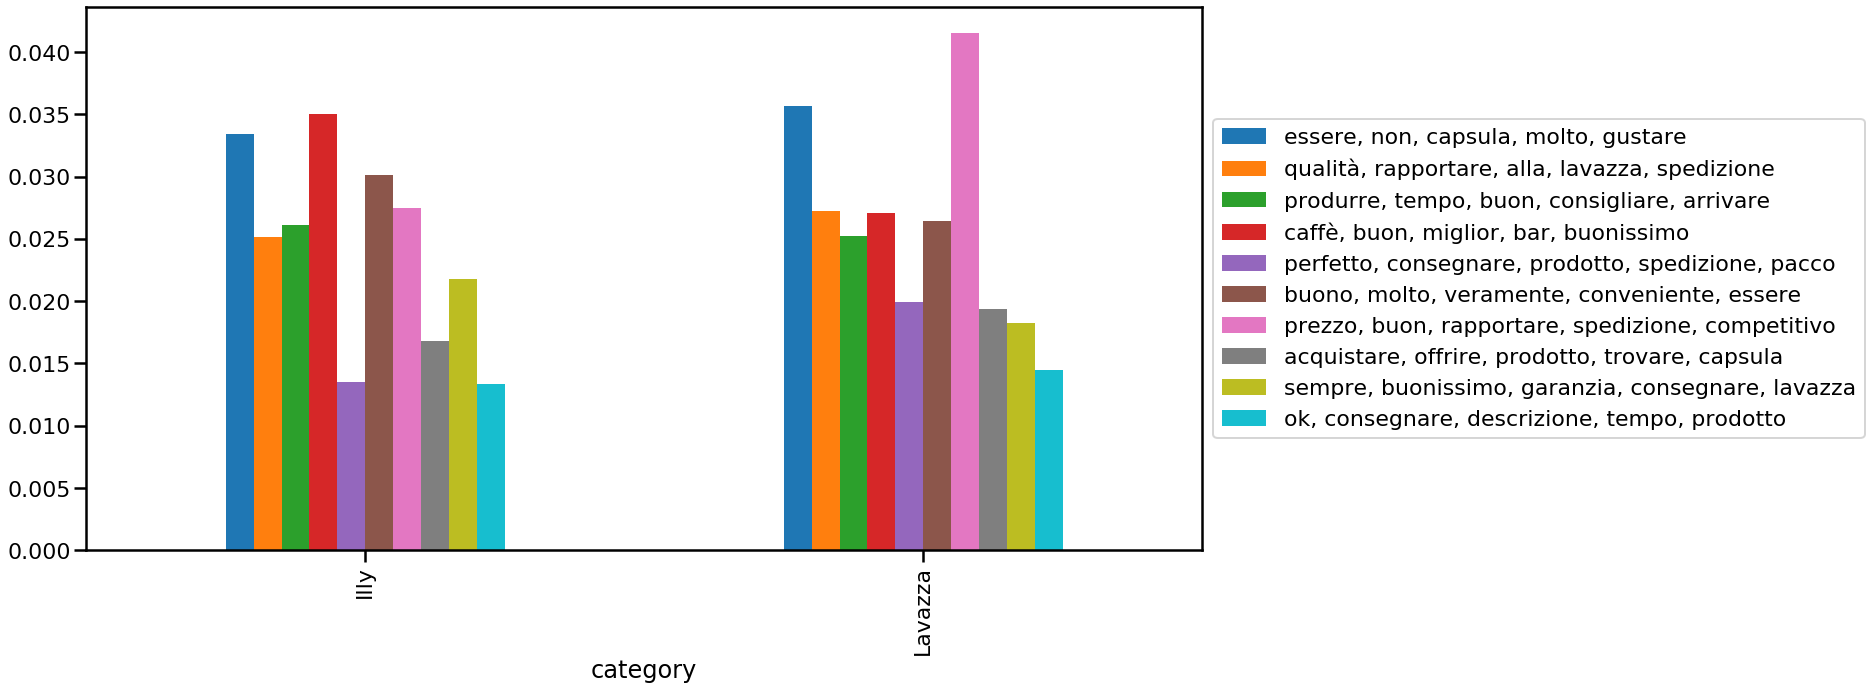

In [124]:
print("\nNMF:")
print(*show_topics(H, terms),sep = "\n")
print('\n')
import matplotlib.pyplot as plt
import seaborn 
seaborn.set_context('poster')
fig, ax = plt.subplots(figsize=(20, 10))

# aggregate topics by categories
POD_aggregate_by_category = POD_topic_distros[POD_topic_distros.category.isin('Illy Lavazza'.split())]
POD_aggregate_by_category = POD_aggregate_by_category.groupby(POD_aggregate_by_category.category).mean()

# plot the graph
POD_aggregate_by_category[POD_descriptors].plot.bar(ax=ax)

# move the legend out
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

In [102]:
POD_aggregate_by_category

,"essere, non, capsula, molto, acquistare","prezzo, qualità, qualità prezzo, rapportare, rapportare qualità","produrre, tempo, buon, consegnare, produrre essere","perfetto, consegnare, prodotto, sempre, tempo","caffè, buon, buon caffè, buonissimo, caffè essere","buono, molto buono, molto, caffè molto, caffè essere"
category,,,,,,
Illy,0.038016,0.028520,0.025840,0.016725,0.042761,0.030945
Lavazza,0.042457,0.038496,0.025273,0.023689,0.033932,0.027546
